Imports

In [61]:
import os
import matplotlib.pyplot as plt
import numpy as np
import json
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler

import torch
import torchvision.models as models
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
from torchvision.models import ResNet50_Weights


In [62]:
# label definitions
ALLERGENS = [
    "Cereals containing gluten", "Crustaceans", "Eggs", "Fish",
    "Peanuts", "Soybeans", "Milk", "Nuts", "Celery", "Mustard",
    "Sesame seeds",  "Sulphur dioxide and sulphites", "Lupin", "Molluscs"
]

Data Loading

In [63]:
dataset_directory = "../Dataset Generation/dataset"

# Image and label directory arrays
images = []
labels = []

for recipe_folder in os.listdir(dataset_directory):
    recipe_path = os.path.join(dataset_directory, recipe_folder)
    allergens_file = os.path.join(recipe_path, 'allergens.json')

    if os.path.isfile(allergens_file):
        with open(allergens_file, 'r') as f:
            data = json.load(f)
            allergens = data['allergens']

            for image in data['images']:
                images.append(os.path.join(dataset_directory, recipe_folder, image))
                labels.append(allergens)

x = np.array(images).reshape(-1,1) # iterative_train_test_split expects 2d array
y = np.array(labels)

Dataset Loader

In [64]:
# Dataset loader class shell: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files

class FoodAllergenDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, target_transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx][0]
        image = Image.open(img_path).convert('RGB') # Convert all images to 3 channel RGB as dataset contains some 4 channel RGBA images
        label = torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

EarlyStopping

In [65]:
"""
https://www.geeksforgeeks.org/how-to-handle-overfitting-in-pytorch-models-using-early-stopping/

patience: Number of epochs to wait before stopping if no improvement.
delta: Minimum change in the monitored quantity to qualify as an improvement.
best_score, best_model_state: Track the best validation score and model state.
call method: Updates the early stopping logic.
"""

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

Model Saving

In [66]:
# https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model(epoch, model, optimizer, training_losses, validation_losses, filename):
    torch.save({
        "epoch": epoch+1,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "training_losses": training_losses, # full loss history, so that post-checkpoint models will have correct loss graph
        "validation_losses": validation_losses
    }, filename)

Training Function

In [67]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
def train_one_epoch(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0.0

    for batch, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        prediction = model(images)
        loss = loss_fn(prediction, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # Accumulate loss for this batch
        total_loss += loss.item()

        if batch % 100 == 0:
            current = batch * len(images)
            print(f"Loss: {loss.item():.7f} [{current:5d}/{size:5d}]")

    avg_train_loss = total_loss / len(dataloader)
    print(f"Train loss for this epoch: {avg_train_loss:.7f}")

    # Return average training loss for this epoch
    return avg_train_loss

Validation Function

In [68]:
def validate_one_epoch(dataloader, model, loss_fn, device):
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            prediction = model(images)
            loss = loss_fn(prediction, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(dataloader)
    print(f"Validation loss for this epoch: {avg_val_loss:.7f}")

    # Return average validation loss for this epoch
    return avg_val_loss

Testing Function

In [69]:
# https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def test_loop(dataloader, model, hyperparameters, device, label):
    model.eval()
    total, correct = 0, 0
    all_predictions = []
    all_actual = []

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputLogits = model(images)
            probs = torch.sigmoid(outputLogits) # # Apply sigmoid to convert logits to get probabilities 0-1
            preds = (probs > hyperparameters['prediction_threshold']) # Get binary predictions based on prediction threshold param

            total += labels.numel()
            correct += (preds == labels).sum().item()

            all_predictions.append(preds.cpu().numpy())
            all_actual.append(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Error: \n Accuracy: {accuracy:.2f} % \n\n')

    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actual = np.concatenate(all_actual, axis=0)

    matrix = confusion_matrix(all_actual, all_predictions)
    plt.figure(figsize=(4, 3))
    sns.heatmap(
        matrix,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar=False,
        xticklabels=["Pred Negative", "Pred Positive"],
        yticklabels=["True Negative", "True Positive"]
    )
    plt.title(f"Confusion Matrix: {ALLERGENS[label]}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    print("\n\nClassification Report:")
    # Sklearn classification report
    report = classification_report(all_actual, all_predictions)
    print(report)

Training Function for Single Allergen Label

In [81]:
def train_for_allergen_label(label, x, y, hyperparameters):
    y = y[:, label] # get label values for specific allergen label

    positives = np.sum(y==1)
    negatives = np.sum(y==0)
    print(f"Before resampling: {positives} positives, {negatives} negatives")

    resampler = RandomUnderSampler() # create random under sampler from unbalanced-learn library

    x_balanced, y_balanced = resampler.fit_resample(x, y) # balance x and y
    y_balanced = y_balanced.reshape(-1,1) # iterative_train_test_split expects 2d array

    positives = np.sum(y_balanced==1)
    negatives = np.sum(y_balanced==0)
    print(f"After resampling: {positives} positives, {negatives} negatives\n")

    x_train, y_train, x_test, y_test = iterative_train_test_split(x_balanced, y_balanced, 0.2) # train test 80:20 split

    # Transform images to tensors and resize
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Test more transforms later in training to improve accuracy - cropping, rotation, centering, flipping etc.

    train_dataset = FoodAllergenDataset(x_train, y_train, transform=transform)
    val_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)
    test_dataset = FoodAllergenDataset(x_test, y_test, transform=transform)

    # Create Train Test Val DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=hyperparameters['batch_size'], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)
    test_dataloader = DataLoader(test_dataset, batch_size=hyperparameters['batch_size'], shuffle=False)

    # set accelerator device cpu/gpu
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
    print(f"Using {device} device")

    # Define model - ResNet50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    model.fc = nn.Linear(model.fc.in_features, 1) # altered final layer for single output binary classification
    model = model.to(device)

    # Loss function and optimizer
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['learning_rate'])


    epochs = hyperparameters['epochs']
    best_val_loss = 1_000_000.
    best_epoch = 0
    training_losses = []
    validation_losses = []
    early_stopping = EarlyStopping(hyperparameters['patience'], hyperparameters['delta'])

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")

        # Train and validate this epoch
        train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, device)
        val_loss = validate_one_epoch(val_dataloader, model, loss_fn, device)

        # Append losses for this epoch
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        # Save best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            filename = f"{ALLERGENS[label]}.pt"
            # save_model(epoch, model, optimizer, training_losses, validation_losses, filename) # Save best model as checkpoint (larger file), so that training can be resumed
            torch.save(model.state_dict(), filename) # Save best model
            best_epoch = epoch + 1
            print(f"Saved new best model: {filename}")

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping\n")
            break
    print(f"Training Complete\n")

    # load the best model before running test loop
    filename = f"{ALLERGENS[label]}.pt"
    model.load_state_dict(torch.load(filename))

    # Plot train and val losses
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Allergen Label: ' + ALLERGENS[label])
    plt.axvline(x=best_epoch, linestyle='--', label=f'Best Model (Epoch {best_epoch})')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Run test loop. Produces Confusion matrix + classification report
    test_loop(test_dataloader, model, hyperparameters, device, label)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/10
Loss: 0.6973540 [    0/ 3862]
Loss: 0.7025486 [ 3200/ 3862]
Train loss for this epoch: 0.6552179
Validation loss for this epoch: 0.6182545
Saved new best model: Crustaceans.pt

Epoch 2/10
Loss: 0.5807692 [    0/ 3862]
Loss: 0.6705030 [ 3200/ 3862]
Train loss for this epoch: 0.6034125
Validation loss for this epoch: 0.5720716
Saved new best model: Crustaceans.pt

Epoch 3/10
Loss: 0.5316402 [    0/ 3862]
Loss: 0.5730752 [ 3200/ 3862]
Train loss for this epoch: 0.5660572
Validation loss for this epoch: 0.8084369

Epoch 4/10
Loss: 0.4047779 [    0/ 3862]
Loss: 0.4876670 [ 3200/ 3862]
Train loss for this epoch: 0.5111180
Validation loss for this epoch: 0.8680338

Epoch 5/10
Loss: 0.4729535 [    0/ 3862]
Loss: 0.6073089 [ 3200/ 3862]
Train loss for this epoch: 0.4847825
Validation loss for this epoch: 0.5997901

Epoch 6/10
Loss: 0.3251537 [    0/ 3862]
Loss: 0.62

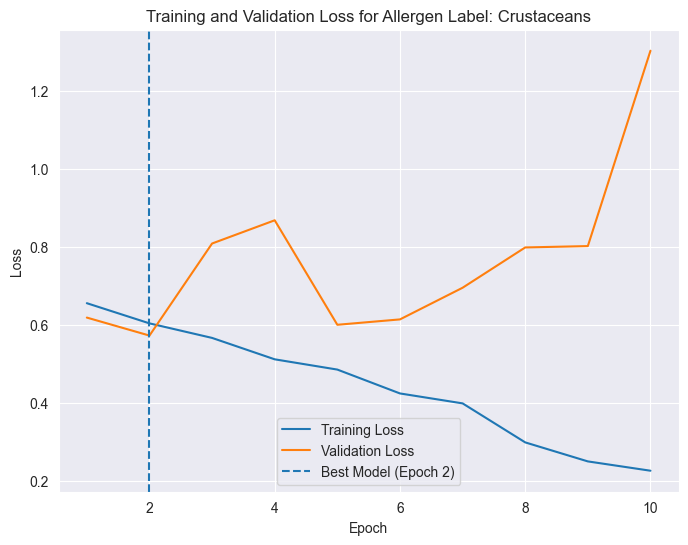

Test Error: 
 Accuracy: 70.39 % 




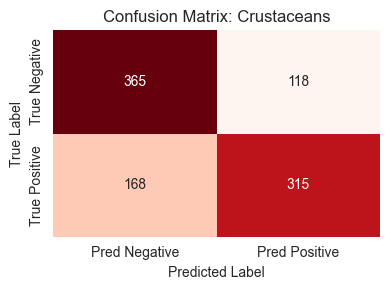



Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.76      0.72       483
         1.0       0.73      0.65      0.69       483

    accuracy                           0.70       966
   macro avg       0.71      0.70      0.70       966
weighted avg       0.71      0.70      0.70       966



In [82]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 1e-3,
    'epochs': 10,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 2414 positives, 59608 negatives
After resampling: 2414 positives, 2414 negatives

Using cuda device

Epoch 1/10
Loss: 0.6884316 [    0/ 3862]
Loss: 0.6371784 [ 3200/ 3862]
Train loss for this epoch: 0.6397636
Validation loss for this epoch: 0.7448611
Saved new best model: Crustaceans.pt

Epoch 2/10
Loss: 0.5444476 [    0/ 3862]
Loss: 0.6503499 [ 3200/ 3862]
Train loss for this epoch: 0.6009559
Validation loss for this epoch: 1.3056135

Epoch 3/10
Loss: 0.6555128 [    0/ 3862]
Loss: 0.6115804 [ 3200/ 3862]
Train loss for this epoch: 0.5690737
Validation loss for this epoch: 0.6066171
Saved new best model: Crustaceans.pt

Epoch 4/10
Loss: 0.5903382 [    0/ 3862]
Loss: 0.6274805 [ 3200/ 3862]
Train loss for this epoch: 0.5463249
Validation loss for this epoch: 0.6312297

Epoch 5/10
Loss: 0.5343622 [    0/ 3862]
Loss: 0.5231863 [ 3200/ 3862]
Train loss for this epoch: 0.4839766
Validation loss for this epoch: 0.6138535

Epoch 6/10
Loss: 0.4400058 [    0/ 3862]
Loss: 0.55

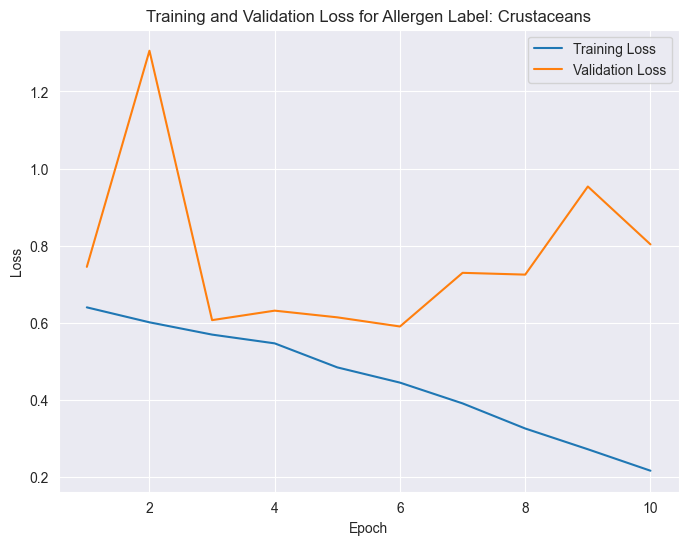

Test Error: 
 Accuracy: 69.25 % 




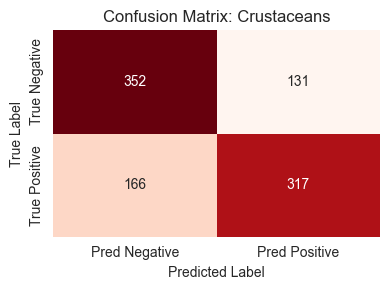



Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.73      0.70       483
         1.0       0.71      0.66      0.68       483

    accuracy                           0.69       966
   macro avg       0.69      0.69      0.69       966
weighted avg       0.69      0.69      0.69       966



In [72]:
hyperparameters = {
    'batch_size': 32,
    'learning_rate': 1e-3,
    'epochs': 10,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(1, x, y, hyperparameters)

Before resampling: 24485 positives, 37537 negatives
After resampling: 24485 positives, 24485 negatives

Using cuda device

Epoch 1/10
Loss: 0.6954644 [    0/39176]
Loss: 0.6622133 [ 6400/39176]
Loss: 0.5897797 [12800/39176]
Loss: 0.6544074 [19200/39176]
Loss: 0.6089075 [25600/39176]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.6288667 [32000/39176]
Loss: 0.5976908 [38400/39176]
Train loss for this epoch: 0.6437141
Validation loss for this epoch: 0.7132492
Saved new best model: Cereals containing gluten.pt

Epoch 2/10
Loss: 0.6075215 [    0/39176]
Loss: 0.6939631 [ 6400/39176]
Loss: 0.5865999 [12800/39176]
Loss: 0.5969458 [19200/39176]
Loss: 0.6015068 [25600/39176]
Loss: 0.5839692 [32000/39176]
Loss: 0.5714979 [38400/39176]
Train loss for this epoch: 0.6240217
Validation loss for this epoch: 0.7137932

Epoch 3/10
Loss: 0.5394561 [    0/39176]
Loss: 0.5753713 [ 6400/39176]
Loss: 0.5462817 [12800/39176]
Loss: 0.5713785 [19200/39176]
Loss: 0.6117549 [25600/39176]
Loss: 0.6744990 [32000/39176]
Loss: 0.6347741 [38400/39176]
Train loss for this epoch: 0.6101791
Validation loss for this epoch: 0.7474189

Epoch 4/10
Loss: 0.5600184 [    0/39176]
Loss: 0.6833918 [ 6400/39176]
Loss: 0.5792257 [12800/39176]
Loss: 0.5744876 [19200/39176]
Loss: 0.5722361 [25600/39176]
Loss: 0.7177870 [32000/39176]
Loss: 0.6137834 

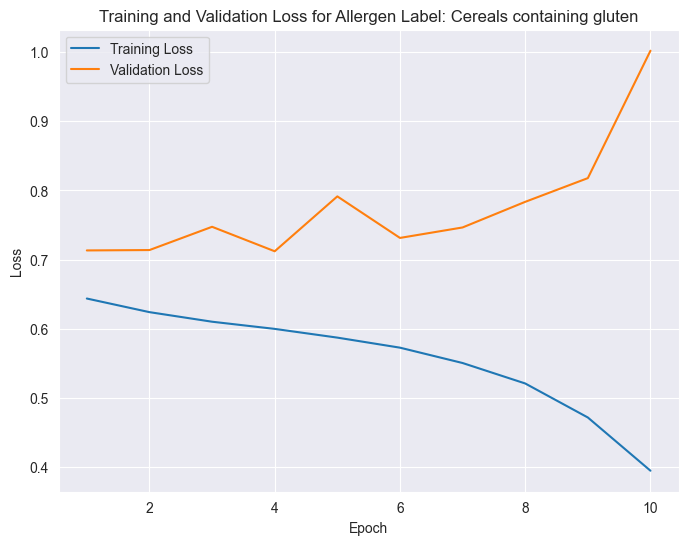

Test Error: 
 Accuracy: 54.18 % 




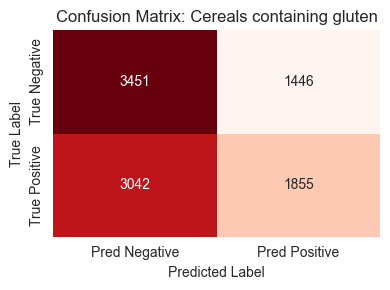



Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.70      0.61      4897
         1.0       0.56      0.38      0.45      4897

    accuracy                           0.54      9794
   macro avg       0.55      0.54      0.53      9794
weighted avg       0.55      0.54      0.53      9794



In [75]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 1e-3,
    'epochs': 10,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(0, x, y, hyperparameters)

Before resampling: 38201 positives, 23821 negatives
After resampling: 23821 positives, 23821 negatives

Using cuda device

Epoch 1/20
Loss: 0.6821166 [    0/38113]
Loss: 0.6528948 [ 6400/38113]


C:\GitHub\FYP\.venv\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Loss: 0.6617637 [12800/38113]
Loss: 0.6600649 [19200/38113]
Loss: 0.6746269 [25600/38113]
Loss: 0.6344092 [32000/38113]
Train loss for this epoch: 0.6493475
Validation loss for this epoch: 0.7203771
Saved new best model: Milk.pt

Epoch 2/20
Loss: 0.6107925 [    0/38113]
Loss: 0.6528397 [ 6400/38113]
Loss: 0.6994396 [12800/38113]
Loss: 0.6295404 [19200/38113]
Loss: 0.6555905 [25600/38113]
Loss: 0.6783010 [32000/38113]
Train loss for this epoch: 0.6291868
Validation loss for this epoch: 0.7154743
Saved new best model: Milk.pt

Epoch 3/20
Loss: 0.6252351 [    0/38113]
Loss: 0.6491871 [ 6400/38113]
Loss: 0.5990890 [12800/38113]
Loss: 0.5760082 [19200/38113]
Loss: 0.5553084 [25600/38113]
Loss: 0.5498281 [32000/38113]
Train loss for this epoch: 0.6159999
Validation loss for this epoch: 0.6897971
Saved new best model: Milk.pt

Epoch 4/20
Loss: 0.6476938 [    0/38113]
Loss: 0.7097384 [ 6400/38113]
Loss: 0.6065428 [12800/38113]
Loss: 0.6569019 [19200/38113]
Loss: 0.5826401 [25600/38113]
Loss: 0

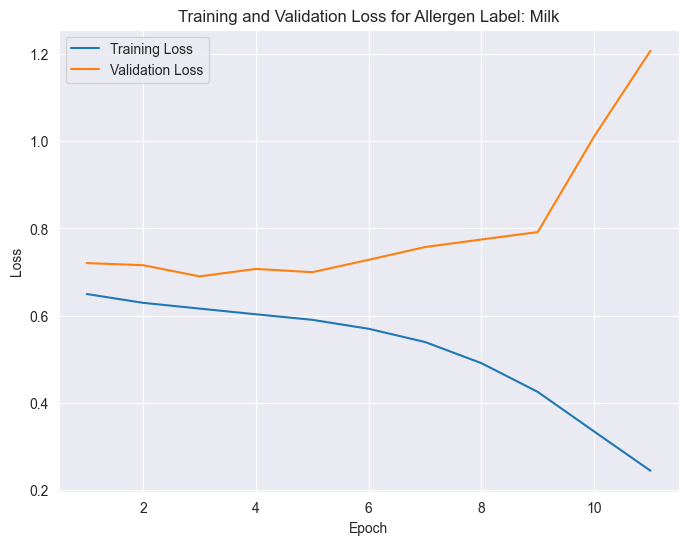

Test Error: 
 Accuracy: 57.73 % 




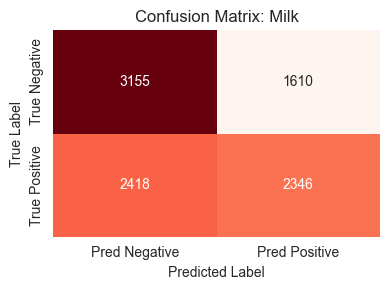



Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.66      0.61      4765
         1.0       0.59      0.49      0.54      4764

    accuracy                           0.58      9529
   macro avg       0.58      0.58      0.57      9529
weighted avg       0.58      0.58      0.57      9529



In [73]:
hyperparameters = {
    'batch_size': 64,
    'learning_rate': 1e-3,
    'epochs': 20,
    'patience': 10,
    'delta': 0.05,
    'prediction_threshold': 0.5
}
train_for_allergen_label(6, x, y, hyperparameters)